# Midterm

## FINM 25000 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Submission
* You will upload your solution to the `Midterm` assignment on Canvas, where you downloaded this. 
* Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.
* If you prompt AI for help, you must cite the AI and the prompt. If you use AI embedded coding tools, cite that you used such tools.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 45     |
| 2       | 40     |
| 3       | 35     |


Each numbered question is worth `5 points` unless otherwise specified.

For every minute late you submit the exam, you will lose `1 point`.

***

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `excess returns` - excess returns of some of the biggest companies in the S&P, along with the SPY ETF.

Note the data is **weekly**, so annualization should use a factor of `52`.

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [ ]:
rets = pd.read_excel(DATAFILE,sheet_name='excess returns')
rets.set_index('date',inplace=True)
rets.columns = [s.split(' ')[0] for s in rets.columns]
rets = rets[info.index]

***

# 1. Risk Statistics and Decomposition

In [ ]:
# Import helper functions from utils

import sys
sys.path.append("commands")
from utils import calc_risk_metrics, calc_return_metrics, calc_performance_metrics, calc_multivariate_regression, calc_mv_portfolio, calc_iterative_regression, calc_univariate_regression


### 1.1. (10pts)

Display a table with the following metrics for each of the return series.

* mean (annualized)
* volatility (annualized)
* Sharpe ratio (annualized)
* skewness
* kurtosis
* maximum drawdown

In [25]:
#Calculate return metrics

excess_returns_df = pd.read_excel(io='midtermdata/midterm_data.xlsx', sheet_name='excess returns',
                                  index_col=0, parse_dates=[0])
excess_returns_df.head(5)

# calculate mean, vol, sharpe ratio
def performance_summary(rets, adj_factor=52):
    summary = {}
    summary["Annualized Mean"] = rets.mean() * adj_factor
    summary["Annualized Volatility"] = rets.std() * np.sqrt(adj_factor)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Mean"] / summary["Annualized Volatility"]
    )
    return pd.DataFrame(summary, index=rets.columns)

metrics = performance_summary(excess_returns_df).sort_values(
    "Annualized Sharpe Ratio", ascending=False
)
display(metrics)

# Calculate skewness, kurtosis, and max drawdown
def risk_summary(rets):
    summary = {}
    summary["Skewness"] = rets.skew()
    summary["Kurtosis"] = rets.kurtosis()
    summary["Max Drawdown"] = rets.apply(lambda x: (x / x.cummax() - 1).min())
    return pd.DataFrame(summary, index=rets.columns)

risk_metrics = risk_summary(excess_returns_df)
display(risk_metrics.sort_values(by=["Skewness", "Kurtosis", "Max Drawdown"], ascending=False))

#Note: Used copilot (GPT4.1) to debug and rearrange functions

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
NVDA,0.653633,0.461871,1.415184
MSFT,0.253320,0.239516,1.057631
AVGO,0.382419,0.375069,1.019597
AMZN,0.300886,0.305453,0.985051
LLY,0.268667,0.283345,0.948195
AAPL,0.227994,0.276003,0.826057
TSLA,0.462420,0.586525,0.788407
GOOGL,0.220044,0.279465,0.787376
META,0.274415,0.352006,0.779574
SPY,0.118939,0.171315,0.694271


,Skewness,Kurtosis,Max Drawdown
AVGO,0.639696,3.515656,-2.260248
GOOGL,0.572854,3.673239,-1.563072
TSLA,0.535479,1.585674,-2.211971
NVDA,0.336949,1.391086,-2.938010
LLY,0.210125,1.638064,-2.237316
MSFT,0.066817,2.372360,-8.064612
META,0.062078,3.990455,-2.541842
AMZN,0.061550,1.754491,-1.779966
BRK-B,-0.199913,2.608872,-20.045113
AAPL,-0.214185,1.852149,-3.216326


### 1.2.

As a standalone investment, which is most attractive? And least? Justify your answer.

- Answer: 
    - As a standalone investment, without taking into consideration of covariances and correlations to other assets in the portfolio, then NVDA is the most attractive if you're willing to take on a little bit more risk (higher vol than average) but NVDA's max drawdown's performance places relatively in the middle in comparison to the other stocks while its sharpe ratio shows the best performance out of all assets.
    - The least attractive standalone investment would be BRK-B, because it has the worst performance when measuring sharpe ratio and has the worst max drawdown.

### 1.3. (10pts)

For each investment, estimate a regression against `SPY`. Report the 
* alpha (annualized as a mean)
* beta
* info ratio
* r-squared

In [32]:
def calc_univariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a univariate regression of y on X. Note that both X and y
    need to be one-dimensional.

    Args:
        y : target variable
        X : independent variable
        intercept (bool, optional): Fit the regression with an intercept or not. Defaults to True.
        adj (int, optional): What to adjust the returns by. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    X_down = X[X.iloc[:, 0] < 0].copy()
    y_down = y[X.iloc[:, 0] < 0].copy()
    if intercept:
        X = sm.add_constant(X)
        X_down = sm.add_constant(X_down)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    inter = results.params.iloc[0] if intercept else 0
    beta = results.params.iloc[1] if intercept else results.params.iloc[0]

    summary = dict()

    summary["Alpha"] = inter * adj
    summary["Beta"] = beta

    down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
    summary["Downside Beta"] = down_mod.params.iloc[1] if intercept else down_mod.params.iloc[0]
    summary["R-Squared"] = results.rsquared
    summary["Treynor Ratio"] = (y.mean() / beta) * adj
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )
    
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)

results = []
for col in ['NVDA', 'MSFT', 'AVGO', 'AMZN', 'LLY', 'AAPL', 'TSLA', 'GOOGL', 'META', 'SPY', 'BRK-B']:
    res = calc_univariate_regression(
        excess_returns_df[[col]],
        excess_returns_df[['SPY']]
    )
    results.append(res)
display(pd.concat(results))

# Note: Used copilot (GPT4.1) to debug and rearrange functions
# above function is from commands/utils.py

,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
NVDA,1.037149e-01,1.716860,1.455785,0.405526,0.087857,0.606268,1.425591e-02
MSFT,3.038843e-02,1.022681,0.824674,0.535057,0.057162,0.387333,6.537967e-03
AVGO,5.103800e-02,1.355773,1.226008,0.383480,0.065092,0.360762,1.178941e-02
AMZN,4.032771e-02,1.060484,0.828316,0.353762,0.065475,0.341881,9.829875e-03
LLY,4.507275e-02,0.616715,0.773677,0.139036,0.100533,0.356875,1.052486e-02
AAPL,2.227186e-02,1.105465,1.089643,0.470818,0.047595,0.230914,8.037563e-03
TSLA,5.954205e-02,1.718565,1.521653,0.251971,0.062094,0.244337,2.030736e-02
GOOGL,2.166231e-02,1.060832,0.923081,0.422891,0.047868,0.212402,8.498938e-03
META,3.166058e-02,1.153691,1.143378,0.315260,0.054890,0.226265,1.166059e-02
SPY,-1.138412e-18,1.000000,1.000000,1.000000,0.027447,-0.062882,1.508652e-18


### 1.4.

Based on this table, which investment seems most attractive relative to holding `SPY`? Justify your answer.


- Answer: Looking at the table above, NVDA seems to be the most attractive relative to SPY. It has the highest alpha and information ratio, indicating it delivers the most excess return and risk-adjusted performance beyond what is explained by SPY. This data suggests that NVDA adds the most value as an active investment compared to simply holding SPY in comaprison to other investments, hence the most attractive.

### 1.5.

Suppose you expect `AAPL` to do well relatively, but you want to hedge broad market risk (`SPY`) and A.I. risk (`NVDA`). 

For every $100 in `AAPL`, what should you hold in `SPY` and `NVDA`?

Estimate the regression including an intercept.

In [65]:
# Multiple regression: regress AAPL on SPY and NVDA (with intercept)
X = excess_returns_df[['SPY', 'NVDA']]
y = excess_returns_df['AAPL']
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop')
results = model.fit()
print(results.summary())

# Extract hedge ratios
beta_spy = results.params['SPY']
beta_nvda = results.params['NVDA']

print(f"For every $100 in AAPL, hold {-beta_spy*100:.2f} in SPY and {-beta_nvda*100:.2f} in NVDA to hedge market and AI risk.")

# Used copilot for coding help, asked copilot chat with the prompt "how to create a regression with an intercept for AAPL with SPY and NVDA as independent variables"

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     246.5
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           6.22e-77
Time:                        20:22:50   Log-Likelihood:                 1185.6
No. Observations:                 547   AIC:                            -2365.
Df Residuals:                     544   BIC:                            -2352.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.158      0.2

- Answer: coef SPY = 1.0154 * 100 = 101.54, coef NVDA = 0.0524 * 100 = 5.24. Take 101.54 + 5.24 = 106.78.
- should invest 101.54/106.78 = 95.09USD in SPY, and 5.24/106.78 = 4.91USD in NVDA



### 1.6.

Without estimating anything new, consider the idea of replicating `AAPL` using `SPY`, and `NVDA`. Which regression statistic best indicates if your replication tracks the target well?

- Answer: The regression statistic that best indicates how well the replication tracks AAPL is the R^2. A higher R^2 means that the data can be explained by the dependent variable well. Therefore a high R^2 means that the replication matches AAPL's returns quite well.

### 1.7.

In the ProShares case, did we find the attempts at hedge-fund replication were successful?

Specifically, did we achieve high **correlation** to the...
* Merril Lynch Benchmark?
    - Answer: Yes, the correlation between HDG and MLFM was around 99%, it's a very successful replication.
* HFRI Index?
    - Answer: Still yes, the correlation between HDG and HFRI Index was around 88%, which is not perfect, but considering that retail investors now have access to hedge-fund like strategies, it is also considered successful.

Were there any drawbacks to using our replication rather than the direct product?
- Answer: The HFRI is dated monthly whihc means it does not have a lot of data, suggesting a low statistical power so even as a reference, it is still not exactly the same as the direct product. Since HDG tracks MLFM which is a linear factor decomposition model of HFRI, and it isn't the direct product, HDG does not have the best flexibility when new information comes into play.

***

# 2. Portfolio Allocation

### 2.1.

Display the correlation matrix of the returns.

Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return? Explain.

<Axes: >

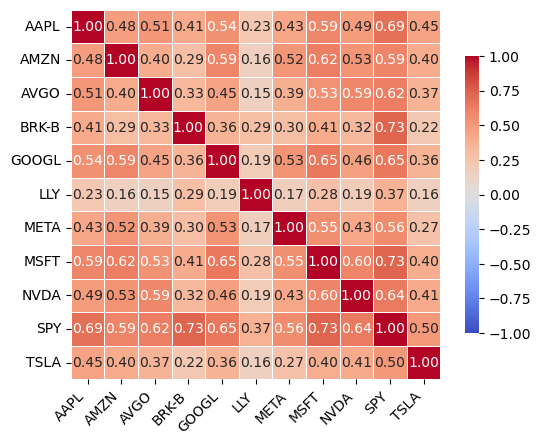

In [37]:
def plot_correlation_matrix(corrs, ax=None):
    if ax:
        sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
            ax=ax,
        )
    # Correlation helper function.
    else:
        ax = sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
        )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    return ax

display(plot_correlation_matrix(excess_returns_df.corr()))

- Answer: Since we're looking at the correlation matrix of all assets including SPY. The investment with the lowest correlation to the rest of the portfolio, especially SPY since SPY includes all the other assets, will get the most weight due to diversification effects. Because in this case, individual performance does not matter as much as how it compares and correlates to the rest of the portfolio. LLY will likely get higher weight for being the least correlated asset comparing to others.

### 2.2.

Calculate and report the weights of the mean-variance optimized portfolio, also called the tangency portfolio. 

*Note that these are excess returns.*

In [ ]:
# Calculating Tangency Portfolio Weights (From HW1)

def tan_portfolio_weights(dataframe, title):
    """
    This function calculates the tengency portfolio weights.

    Args:
        dataframe: a dataframe of excess returns

    Returns:
        A vector of tangency portfolio weights.
    """
    mean_returns = dataframe.mean()
    Sigma = dataframe.cov()

    inv_Sigma = np.linalg.inv(Sigma) # inverse of sigma

    ones = np.ones(mean_returns.shape)

    unscaled_portfolio_weights = inv_Sigma @ mean_returns # cov matrix times mean returns vector
    sum_unscaled_portfolio_weights = ones.T @ inv_Sigma @ mean_returns # scalar
    weights = unscaled_portfolio_weights / sum_unscaled_portfolio_weights #normalization of weights

    #convert to dataframe
    w_tan_df = pd.DataFrame(weights, 
                        index = dataframe.columns, 
                        columns = [title]
                        )
    return w_tan_df

w_tan_df = tan_portfolio_weights(excess_returns_df, 'Tangency Portfolio')



print("Tangency Portfolio Weights: ")
display(w_tan_df.sort_values(by='Tangency Portfolio', ascending=False))
print()
print("Annualized Sharpe Ratio of each asset (annualized):")
display(metrics['Annualized Sharpe Ratio'].sort_values(ascending=False))

w_tan_returns = excess_returns_df @ w_tan_df

Tangency Portfolio Weights: 


,Tangency Portfolio
BRK-B,3.084359
LLY,1.202377
NVDA,1.067801
MSFT,0.859136
AVGO,0.645620
AMZN,0.536354
AAPL,0.477018
META,0.385017
TSLA,0.337308
GOOGL,0.298598



Annualized Sharpe Ratio of each asset (annualized):


NVDA     1.415184
MSFT     1.057631
AVGO     1.019597
AMZN     0.985051
LLY      0.948195
AAPL     0.826057
TSLA     0.788407
GOOGL    0.787376
META     0.779574
SPY      0.694271
BRK-B    0.685508
Name: Annualized Sharpe Ratio, dtype: float64

### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.
* mean
* volatility
* Sharpe

(Annualize all three statistics.)

In [43]:
tan_summary = performance_summary(w_tan_returns)
print()
display(tan_summary)

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
Tangency Portfolio,1.545781,0.723538,2.136419


### 2.4.

Consider the biggest positive weight (long) and most negative weight (short).

Do they align with the most extreme Sharpe ratios? Explain.

- Answer: No, the biggest positive weight and the most negative weight in the tangency portfolio do not align with the most extreme sharpe ratios because individual sharpe ratio measures individual performance. The tangency portfolio weights take into much bigger account of the covariances and correlations between each asset in the portfolio and consider very little of individual performances. Even if an asset performed well by itself, if it's highly correlated with many of the other assets in the portfolio, it'll will be heavily counted against in the tangency portfolio weights.

### 2.5.

Try dropping `SPY` from the set of assets. 

Re-run the optimization and report the new tangency weights.

In [46]:
# Dropped SPY main strategy (From HW1):

new_tickers = ['NVDA', 'MSFT', 'AVGO', 'AMZN', 'LLY', 'AAPL', 'TSLA', 'GOOGL', 'META', 'BRK-B']
w_tan_no_spy_df = tan_portfolio_weights(excess_returns_df[new_tickers], 
                                         'Tangency Portfolio (with no spy)')

print("Tangency Portfolio Weights: ")
display(w_tan_no_spy_df.sort_values(by='Tangency Portfolio (with no spy)', ascending=False))

w_tan_returns_no_spy = excess_returns_df[new_tickers] @ w_tan_no_spy_df

tan_summary_no_spy = performance_summary(w_tan_returns_no_spy)
print()
display(tan_summary_no_spy)

Tangency Portfolio Weights: 


,Tangency Portfolio (with no spy)
LLY,0.399535
NVDA,0.370675
AMZN,0.145160
AVGO,0.104653
BRK-B,0.047814
TSLA,0.038724
META,0.028621
MSFT,0.014582
GOOGL,-0.071598
AAPL,-0.078166


,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
Tangency Portfolio (with no spy),0.43543,0.270785,1.608027


### 2.6.

Mark each of the statements as `True or False`. No justification is needed.

In our analysis of the multi-asset portfolio optimization, we found that a change in TIPS mean excess returns caused a large change in the...

* performance of the tangency portfolio.
    - Answer: False
* weights of the tangency portfolio.
    - Answer: True
* correlation structure of the assets.
    - Answer: False

### 2.7. (10pts)

1. Briefly explain why the optimized portfolio is unrealistic in practice.
- Answer: The optimizer takes the tangency portfolio weights way too seriously because it emphasizes too much on the best performing asset and plays too much against the asset that is the most correlated with the best performing asset in an exaggerated attempt at diversification, totally ignoring whether the decision is realistic or not. This results in lots of corner solutions which are not good.

1. What does Harvard do to make the optimization more practical.
- Answer: Harvard's solution was to create a convex optimization with convex constraints so the optimizer doesn't take the portfolio weight out of proportion for the assets. Performance will then be more stable but they are playing it safer by cutting off possibility for even higher returns or losses but it creates realistic weights unlike the optimizer tangency for the portfolio.

1. Why did Harvard optimize in levels (securities within an asset class, then all the broad asset classes) rather than direclty optimizing all the securities.
- Answer: Because let's say if Harvard tried to use 1000 individual equities, the covariances of the 1000 individual equities are mathematically ok but not ideal or useful statistically because there's too much data for a clearer understanding. Since the tangency of portfolio is depedent on the vector of mean returns, dividing them into asset classes is better for comparison and calculation.

****

# 3. Expected Returns

### 3.1.

Consider the CAPM as tested with a single stock,

$$\mathbb{E}\left[r\right] = \beta\,  \mathbb{E}\left[x\right]$$

where
* $r$ denotes the return on `NVDA`, and ETF for U.S. oil
* $x$ denotes the returns on `SPY`, an ETF for USD currency trades.

Estimate the associated regression,
$$r_t = \alpha + \beta x_t + \epsilon_t$$

Report,
* $\alpha$
* $\beta$
* r-squared

Annualize alpha.

In [53]:
# CAPM regression: NVDA excess returns on SPY excess returns
y = excess_returns_df['NVDA']
X = excess_returns_df[['SPY']]
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop')
results = model.fit()

# Extract regression statistics
alpha = results.params['const']
beta = results.params['SPY']
r_squared = results.rsquared

print(f"Alpha (annualized): {alpha * 52:.6f}")
print(f"Beta: {beta:.4f}")
print(f"R-squared: {r_squared:.4f}")

results.summary()

# Note: Used copilot (GPT4.1) to correct the regression code and to extract the alpha, beta, and R-squared values.
# prompt: "what should i fix in cell 52 to make the regression work? i want to regress NVDA excess returns on SPY excess returns and get the alpha, beta, and R-squared values"

Alpha (annualized): 0.449431
Beta: 1.7169
R-squared: 0.4055


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NVDA   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     371.8
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           1.51e-63
Time:                        19:53:26   Log-Likelihood:                 869.79
No. Observations:                 547   AIC:                            -1736.
Df Residuals:                     545   BIC:                            -1727.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.002      4.071      0.000       0.004       0.013
SPY            1.7169      0.089     19.282      0.000       1.542       1.892
==============================================================================
Omnibus:                       67.982   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.104
Skew:                           0.578   Prob(JB):                     6.47e-46
Kurtosis:                       5.792   Cond. No.                         42.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2.

What evidence is there that this (simplistic) factor pricing model does not price `NVDA` correctly?

- Answer: Alpha is 0.0086 which is statiscally different from 0, suggesting a failure of CAPM since CAPM assumes all alpha = 0 or indistinguishable from 0 and the R^2 is no where near 1 which suggests that the model does not explain NVDA well.

### 3.3.

What is the (annualized) average excess return of `NVDA`?

According to the CAPM, what level of average excess return is explained by the factor risk?

In [55]:
# Annualized average excess return of NVDA
annualized_mean_nvda = excess_returns_df['NVDA'].mean() * 52
print(f"Annualized Average Excess Return of NVDA: {annualized_mean_nvda:.6f}")

# Check the level of average excess return explained by the CAPM model
capm_explained_return = beta * excess_returns_df['SPY'].mean() * 52
print(f"CAPM Explained Return: {capm_explained_return:.6f}")

# Note: Used copilot (GPT4.1) to help complete the code by using suggestions and debugging the code.

Annualized Average Excess Return of NVDA: 0.653633
CAPM Explained Return: 0.204202


### 3.4.

Now let's disregard the equilibrium pricing model above, and try calculating the expected return of `NVDA` via forecasting signals. To keep things simple, just use a forecasting regression (rather than a neural network, regression tree, etc.)
$$r_{t+1} = \alpha + \beta x_t + \epsilon_{t+1}$$

We estimate a forecasting regression of `NVDA` on `SPY`.


From this **forecasting** regression, report
* $\alpha$
* $\beta$
* r-squared

In [61]:
# lagged regression of NVDA on SPY (Function from HW4)

def lagged_regression(Y, X, reg_name):
    """
    Lagged regression of Y on X (handles univariate/multivariate X).
    Returns DataFrame with Alpha, Beta(s), and R-Squared.
    """
    X_lag = X.shift(1).dropna()

    # Shift the explanatory variable down 1 & drop na rows
    X_lag = X.shift(1).dropna()

    # Align response indices with X_lag indices
    Y = Y.loc[X_lag.index]

    # set-up of Ordinary Least Sqaured Regression (drop missing values & add constant for regression)
    results = sm.OLS(Y, sm.add_constant(X_lag), missing = 'drop').fit()

    # constant and slope of explanatory variable (index 0 and 1 respectively)
    parameters = results.params

    intercept = parameters.iloc[0] # returns in excess of the market

    summary = dict()
    summary['Alpha'] = intercept
    summary['R-Squared'] = results.rsquared

    if isinstance(X, pd.Series):
        summary['Beta'] = parameters.iloc[1]
    else: # The multivariate case
        for col, beta_val in parameters.iloc[1:].items():
            summary[f'{col} Beta'] = beta_val

    return pd.DataFrame([summary], index=[reg_name])

# Lagged regression of NVDA on SPY
lagged_nvda_spy = lagged_regression(excess_returns_df['NVDA'],  
                                    excess_returns_df['SPY'], 
                                    'NVDA on SPY')
display(lagged_nvda_spy)

# Note: Used copilot (GPT4.1) to help complete the code by using suggestions and debugging the code.


,Alpha,R-Squared,Beta
NVDA on SPY,0.013119,0.007127,-0.227943


### 3.5.

Given the stats in `3.4.`, what do you think of this forecast for `NVDA`? Be specific.

- Answer: This forecast for NVDA is not useful. The R-squared is extremely low (0.007), meaning SPY explains almost none of NVDA's future returns. The negative beta and small alpha further suggest the model lacks predictive power. In summary, SPY returns do not help forecast NVDA returns in this setup.

- Note: Used copilot (GPT-4.1) to interpret data, prompt "regressed NVDA on SPY with Alpha = 0.013119, R^2 = 0.007127, Beta = -0.227943, how is this forecast for NVDA?"

### 3.6.

According to the signal forecasting model, what is the expected return (annualized) of `NVDA` in `July 2025`?

In [64]:
# Get the last available SPY excess return (June 2025)
last_spy = excess_returns_df['SPY'].iloc[-1]

# Use the estimated alpha and beta from the lagged regression
alpha = lagged_nvda_spy['Alpha'].iloc[0]
beta = lagged_nvda_spy['Beta'].iloc[0]

# Forecast NVDA return for July 2025 (weekly)
forecast_nvda_weekly = alpha + beta * last_spy

# Annualize the forecast
forecast_nvda_annualized = forecast_nvda_weekly * 52
print(f"Forecasted annualized NVDA excess return for July 2025: {forecast_nvda_annualized:.6f}")

# Note: Used copilot (GPT4.1) to help write the code, prompt "According to the forecasting model shown in 3.4 (cell 61), what is the expected return (annualized) for NVDA in July 2025?"

Forecasted annualized NVDA excess return for July 2025: 0.281449


### 3.7.

Why is it important to create style factors which go **long** and **short** the targeted style?

- Answer: It's because that factors like value or size typically have around 90% correlation with the market factor as mentioned in lecture, so it's not useful if we just long or short it. Using the strategy of long AND short will ensure the correlation with other factors used in the model stays low.

****